In [72]:
from __future__ import print_function

from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time

In [73]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        ############################
        #### Put your code here ####
        ############################
        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),    # 6*26*26
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)), # 6*13*13
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),   # 16*8*8
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU())
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(84, 10)),
            ('sig7', nn.LogSoftmax(dim=-1))
        ]))
        ###########################
        #### End of your codes ####
        ###########################

    def forward(self, x):
        ############################
        #### Put your code here ####
        ############################
        x = self.convnet(x)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        ###########################
        #### End of your codes ####
        ###########################

        return out


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    count = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        ############################
        #### Put your code here ####
        ############################
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        ###########################
        #### End of your codes ####
        ###########################
        # if batch_idx % 10 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset)

In [74]:
batch_size = 128
epochs = 50
# no_cuda = False
save_model = False
use_cuda = torch.cuda.is_available()
torch.manual_seed(100)
# device = torch.device("cuda" if use_cuda else "cpu")
device = torch.device("mps")

transform = transforms.Compose([
    torchvision.transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [77]:
SGD_params = [{'lr': 0.1, 'momentum': 0.9, 'weight_decay': 5e-4}, {'lr': 0.05, 'momentum': 0.9, 'weight_decay': 5e-4}, {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 5e-4}, {'lr': 0.005, 'momentum': 0.9, 'weight_decay': 5e-4}, {'lr': 0.001, 'momentum': 0.9, 'weight_decay': 5e-4}]
SGD_params_Acc = [[], [], [], [], []]
SGD_params_Loss = [[], [], [], [], []]
SGD_params_Time = []

AdaGrad_params = [{'lr': 0.1, 'weight_decay': 5e-4}, {'lr': 0.05, 'weight_decay': 5e-4}, {'lr': 0.01, 'weight_decay': 5e-4}, {'lr': 0.005, 'weight_decay': 5e-4}, {'lr': 0.001, 'weight_decay': 5e-4}]
AdaGrad_params_Acc = [[], [], [], [], []]
AdaGrad_params_Loss = [[], [], [], [], []]
AdaGrad_params_Time = []

RMSprop_params = [{'lr': 0.001, 'alpha': 0.9, 'momentum': 0.1}, {'lr': 0.0005, 'alpha': 0.9, 'momentum': 0.1}, {'lr': 0.0001, 'alpha': 0.9, 'momentum': 0.1}, {'lr': 0.001, 'alpha': 0.95, 'momentum': 0.1}, {'lr': 0.0005, 'alpha': 0.95, 'momentum': 0.1}, {'lr': 0.0001, 'alpha': 0.95, 'momentum': 0.1}, {'lr': 0.001, 'alpha': 0.99, 'momentum': 0.1}, {'lr': 0.0005, 'alpha': 0.99, 'momentum': 0.1}, {'lr': 0.0001, 'alpha': 0.99, 'momentum': 0.1}]

RMSprop_params_Acc = [[], [], [], [], [], [], [], [], []]
RMSprop_params_Loss = [[], [], [], [], [], [], [], [], []]
RMSprop_params_Time = []

In [79]:
for i in range(len(SGD_params)):
    model = LeNet().to(device)
    optimizer = optim.SGD(model.parameters(), **SGD_params[i])

    time0 = time.time()
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        loss, acc = test(model, device, test_loader)
        SGD_params_Acc[i].append(acc)
        SGD_params_Loss[i].append(loss)

    time1 = time.time()
    SGD_params_Time.append(time1 - time0)


Test set: Average loss: 0.1884, Accuracy: 9475/10000 (95%)


Test set: Average loss: 0.1229, Accuracy: 9630/10000 (96%)


Test set: Average loss: 0.1203, Accuracy: 9650/10000 (96%)


Test set: Average loss: 0.0989, Accuracy: 9715/10000 (97%)


Test set: Average loss: 0.0901, Accuracy: 9741/10000 (97%)


Test set: Average loss: 0.0849, Accuracy: 9754/10000 (98%)


Test set: Average loss: 0.1009, Accuracy: 9716/10000 (97%)


Test set: Average loss: 0.0749, Accuracy: 9772/10000 (98%)


Test set: Average loss: 0.0764, Accuracy: 9784/10000 (98%)


Test set: Average loss: 0.0817, Accuracy: 9761/10000 (98%)


Test set: Average loss: 0.0556, Accuracy: 9836/10000 (98%)


Test set: Average loss: 0.0741, Accuracy: 9775/10000 (98%)


Test set: Average loss: 0.0737, Accuracy: 9770/10000 (98%)


Test set: Average loss: 0.0767, Accuracy: 9793/10000 (98%)


Test set: Average loss: 0.0652, Accuracy: 9801/10000 (98%)


Test set: Average loss: 0.0897, Accuracy: 9748/10000 (97%)


Test set: Average loss:

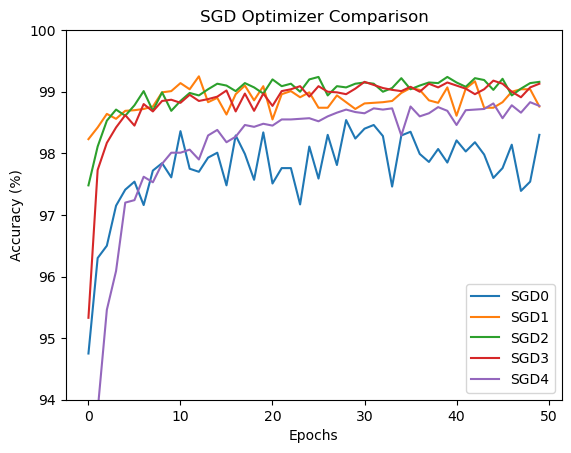

In [124]:
fig, ax = plt.subplots()

for i in range(len(SGD_params_Time)):
    ax.plot(SGD_params_Acc[i], label='SGD' + str(i))

ax.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.ylim(94, 100)
plt.title("SGD Optimizer Comparison")
# plt.show()
plt.savefig("2.1.png")

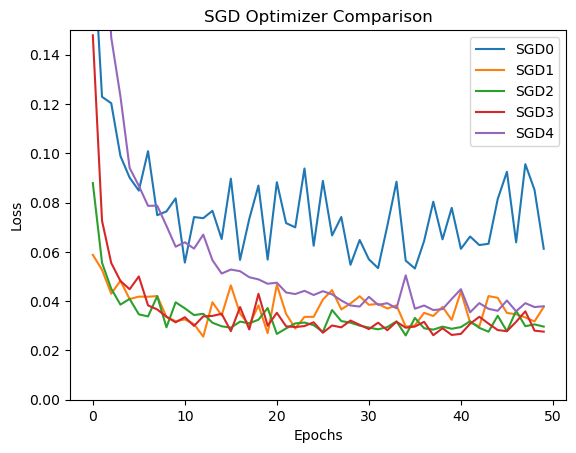

In [130]:
fig, ax = plt.subplots()

for i in range(len(SGD_params_Time)):
    ax.plot(SGD_params_Loss[i], label='SGD' + str(i))

ax.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 0.15)
plt.title("SGD Optimizer Comparison")
# plt.show()
plt.savefig("2.2.png")

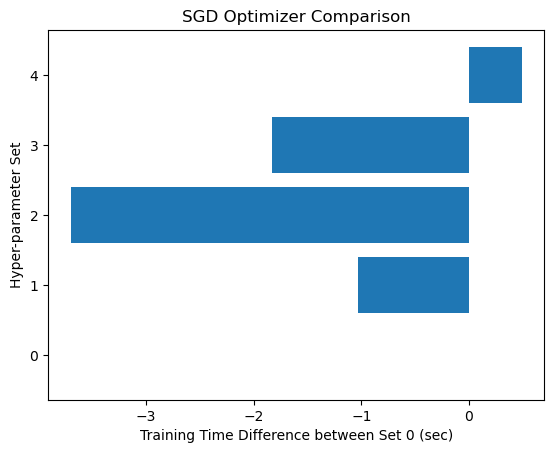

In [155]:
fig, ax = plt.subplots()

ax.barh([i for i in range(len(SGD_params))], [SGD_params_Time[i] - SGD_params_Time[0] for i in range(len(SGD_params))])

plt.ylabel("Hyper-parameter Set")
plt.xlabel("Training Time Difference between Set 0 (sec)")
plt.title("SGD Optimizer Comparison")
# plt.xlim(-5, 5)
# plt.show()
plt.savefig("2.3.png")

In [92]:
for i in range(len(AdaGrad_params)):
    model = LeNet().to(device)
    optimizer = optim.Adagrad(model.parameters(), **AdaGrad_params[i])

    time0 = time.time()
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        loss, acc = test(model, device, test_loader)
        AdaGrad_params_Acc[i].append(acc)
        AdaGrad_params_Loss[i].append(loss)

    time1 = time.time()
    AdaGrad_params_Time.append(time1 - time0)


Test set: Average loss: 0.1683, Accuracy: 9482/10000 (95%)


Test set: Average loss: 0.1091, Accuracy: 9660/10000 (97%)


Test set: Average loss: 0.1042, Accuracy: 9664/10000 (97%)


Test set: Average loss: 0.0825, Accuracy: 9741/10000 (97%)


Test set: Average loss: 0.0739, Accuracy: 9752/10000 (98%)


Test set: Average loss: 0.0758, Accuracy: 9751/10000 (98%)


Test set: Average loss: 0.0702, Accuracy: 9765/10000 (98%)


Test set: Average loss: 0.0646, Accuracy: 9791/10000 (98%)


Test set: Average loss: 0.0668, Accuracy: 9773/10000 (98%)


Test set: Average loss: 0.0609, Accuracy: 9799/10000 (98%)


Test set: Average loss: 0.0673, Accuracy: 9786/10000 (98%)


Test set: Average loss: 0.0575, Accuracy: 9808/10000 (98%)


Test set: Average loss: 0.0639, Accuracy: 9797/10000 (98%)


Test set: Average loss: 0.0680, Accuracy: 9773/10000 (98%)


Test set: Average loss: 0.0609, Accuracy: 9807/10000 (98%)


Test set: Average loss: 0.0541, Accuracy: 9817/10000 (98%)


Test set: Average loss:

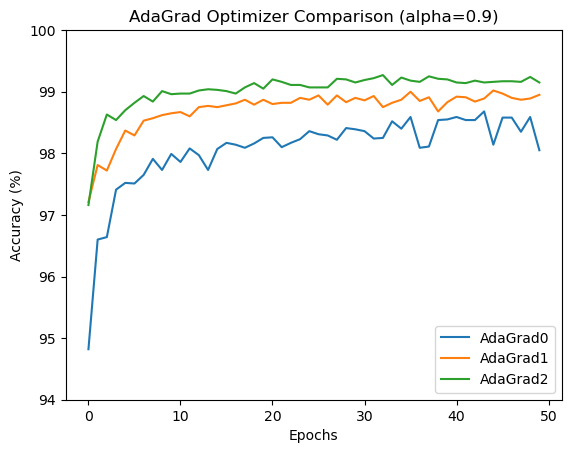

In [136]:
fig, ax = plt.subplots()

for i in range(len(AdaGrad_params)):
    ax.plot(AdaGrad_params_Acc[i], label='AdaGrad' + str(i))

ax.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.ylim(94, 100)
plt.title("AdaGrad Optimizer Comparison")
# plt.show()
plt.savefig("3.1.png")

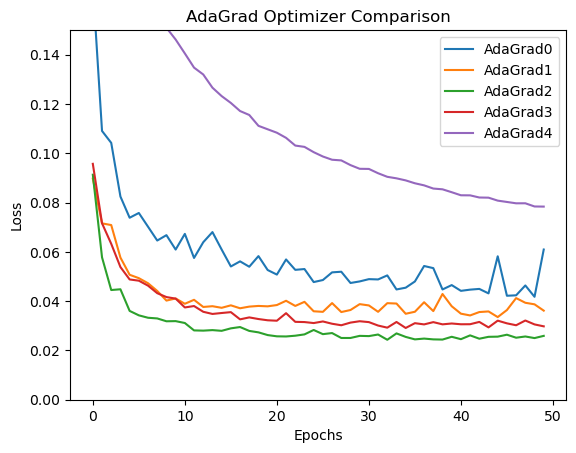

In [141]:
fig, ax = plt.subplots()

for i in range(len(AdaGrad_params)):
    ax.plot(AdaGrad_params_Loss[i], label='AdaGrad' + str(i))

ax.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 0.15)
plt.title("AdaGrad Optimizer Comparison")
# plt.show()
plt.savefig("3.2.png")

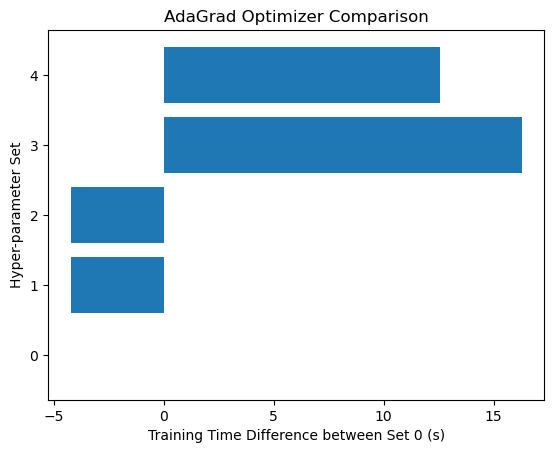

In [154]:
fig, ax = plt.subplots()

ax.barh([i for i in range(len(AdaGrad_params))], [AdaGrad_params_Time[i] - AdaGrad_params_Time[0] for i in range(len(AdaGrad_params))])

plt.ylabel("Hyper-parameter Set")
plt.xlabel("Training Time Difference between Set 0 (s)")
plt.title("AdaGrad Optimizer Comparison")
# plt.xlim(-5, 5)
# plt.show()
plt.savefig("3.3.png")

In [104]:
for i in range(len(RMSprop_params)):
    model = LeNet().to(device)
    optimizer = optim.RMSprop(model.parameters(), **RMSprop_params[i])

    time0 = time.time()
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        loss, acc = test(model, device, test_loader)
        RMSprop_params_Acc[i].append(acc)
        RMSprop_params_Loss[i].append(loss)

    time1 = time.time()
    RMSprop_params_Time.append(time1 - time0)


Test set: Average loss: 0.0494, Accuracy: 9839/10000 (98%)


Test set: Average loss: 0.0376, Accuracy: 9861/10000 (99%)


Test set: Average loss: 0.0367, Accuracy: 9888/10000 (99%)


Test set: Average loss: 0.0286, Accuracy: 9901/10000 (99%)


Test set: Average loss: 0.0345, Accuracy: 9893/10000 (99%)


Test set: Average loss: 0.0367, Accuracy: 9879/10000 (99%)


Test set: Average loss: 0.0279, Accuracy: 9921/10000 (99%)


Test set: Average loss: 0.0407, Accuracy: 9885/10000 (99%)


Test set: Average loss: 0.0319, Accuracy: 9897/10000 (99%)


Test set: Average loss: 0.0367, Accuracy: 9917/10000 (99%)


Test set: Average loss: 0.0377, Accuracy: 9908/10000 (99%)


Test set: Average loss: 0.0337, Accuracy: 9919/10000 (99%)


Test set: Average loss: 0.0344, Accuracy: 9924/10000 (99%)


Test set: Average loss: 0.0393, Accuracy: 9914/10000 (99%)


Test set: Average loss: 0.0426, Accuracy: 9908/10000 (99%)


Test set: Average loss: 0.0415, Accuracy: 9910/10000 (99%)


Test set: Average loss:

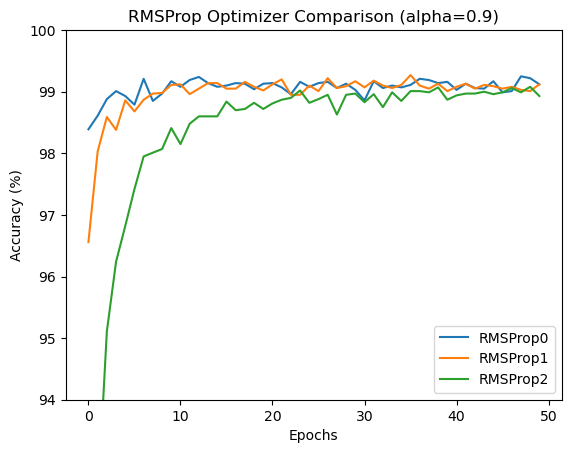

In [167]:
fig, ax = plt.subplots()

for i in range(3):
    ax.plot(RMSprop_params_Acc[i], label='RMSProp' + str(i))

ax.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.ylim(94, 100)
plt.title("RMSProp Optimizer Comparison (alpha=0.9)")
# plt.show()
plt.savefig("4.1.1.png")

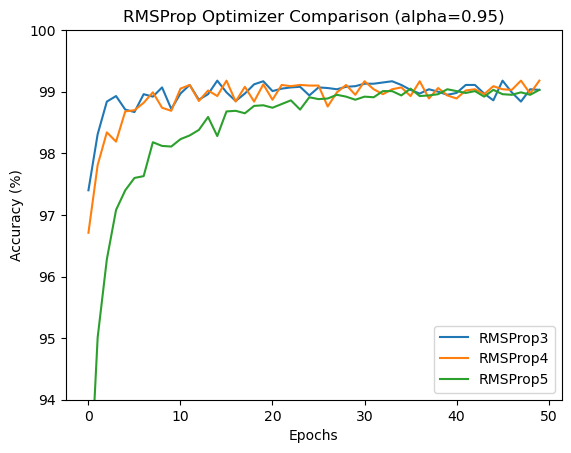

In [168]:
fig, ax = plt.subplots()

for i in range(3):
    ax.plot(RMSprop_params_Acc[3 + i], label='RMSProp' + str(3 + i))

ax.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.ylim(94, 100)
plt.title("RMSProp Optimizer Comparison (alpha=0.95)")
# plt.show()
plt.savefig("4.2.1.png")

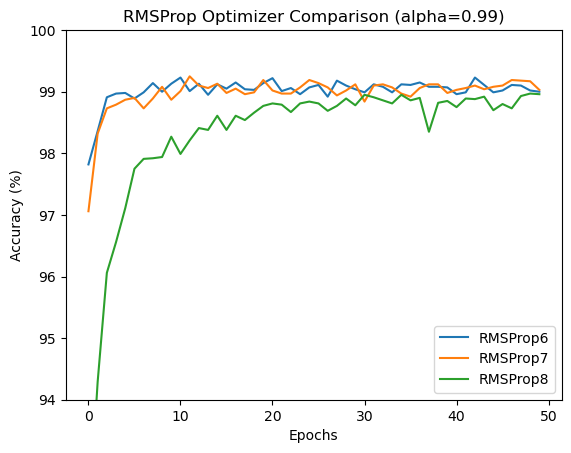

In [169]:
fig, ax = plt.subplots()

for i in range(3):
    ax.plot(RMSprop_params_Acc[6 + i], label='RMSProp' + str(6 + i))

ax.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.ylim(94, 100)
plt.title("RMSProp Optimizer Comparison (alpha=0.99)")
# plt.show()
plt.savefig("4.3.1.png")

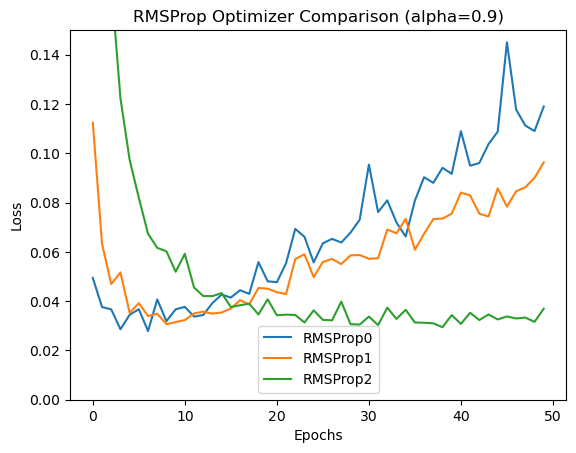

In [191]:
fig, ax = plt.subplots()

for i in range(3):
    ax.plot(RMSprop_params_Loss[i], label='RMSProp' + str(i))

ax.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 0.15)
plt.title("RMSProp Optimizer Comparison (alpha=0.9)")
# plt.show()
plt.savefig("4.1.2.png")

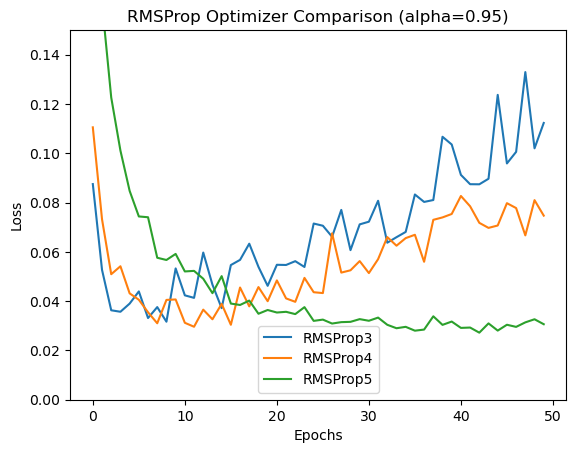

In [192]:
fig, ax = plt.subplots()

for i in range(3):
    ax.plot(RMSprop_params_Loss[3 + i], label='RMSProp' + str(3 + i))

ax.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 0.15)
plt.title("RMSProp Optimizer Comparison (alpha=0.95)")
# plt.show()
plt.savefig("4.2.2.png")

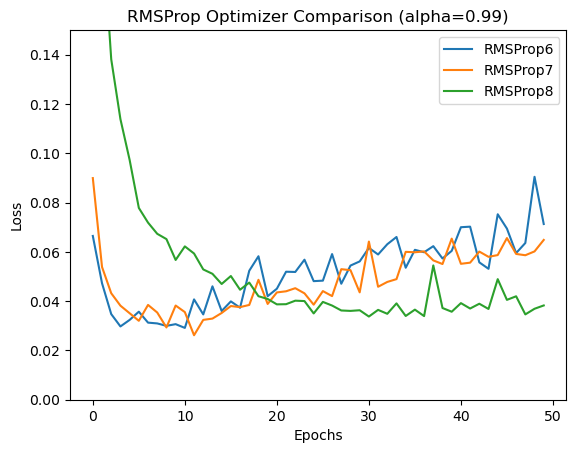

In [193]:
fig, ax = plt.subplots()

for i in range(3):
    ax.plot(RMSprop_params_Loss[6 + i], label='RMSProp' + str(6 + i))

ax.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 0.15)
plt.title("RMSProp Optimizer Comparison (alpha=0.99)")
# plt.show()
plt.savefig("4.3.2.png")

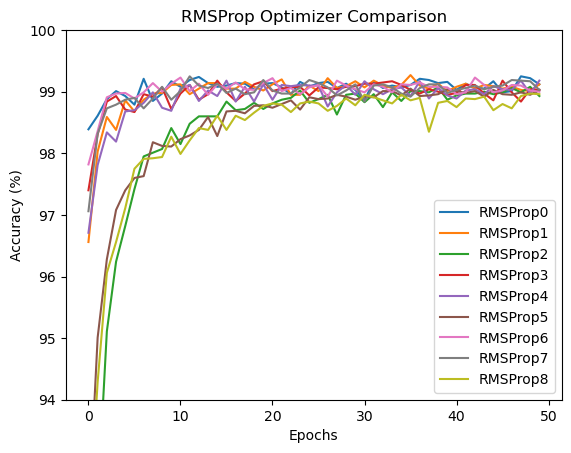

In [195]:
fig, ax = plt.subplots()

for i in range(9):
    ax.plot(RMSprop_params_Acc[i], label='RMSProp' + str(i))

ax.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.ylim(94, 100)
plt.title("RMSProp Optimizer Comparison")
plt.show()

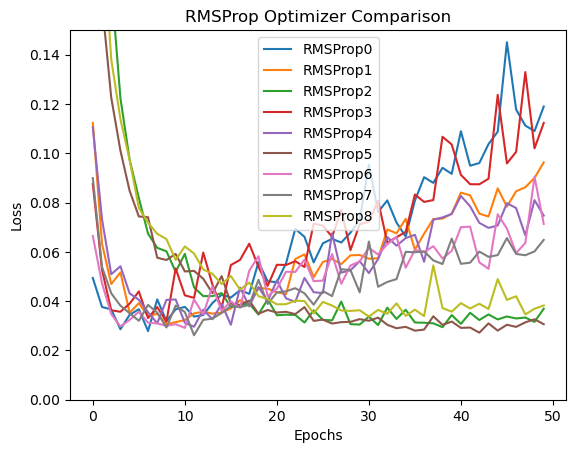

In [194]:
fig, ax = plt.subplots()

for i in range(9):
    ax.plot(RMSprop_params_Loss[i], label='RMSProp' + str(i))

ax.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 0.15)
plt.title("RMSProp Optimizer Comparison")
plt.show()

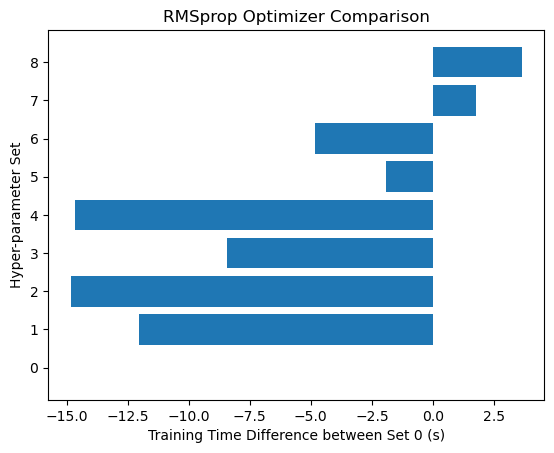

In [157]:
fig, ax = plt.subplots()

ax.barh([i for i in range(len(RMSprop_params))], [RMSprop_params_Time[i] - RMSprop_params_Time[0] for i in range(len(RMSprop_params))])

plt.ylabel("Hyper-parameter Set")
plt.xlabel("Training Time Difference between Set 0 (s)")
plt.title("RMSprop Optimizer Comparison")
plt.yticks([i for i in range(len(RMSprop_params))])
# plt.xlim(-5, 5)
# plt.show()
plt.savefig("4.3.png")

tensor(7)


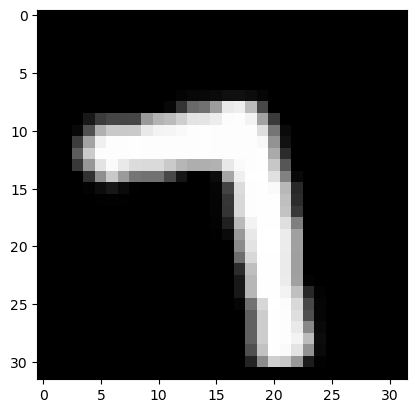

In [190]:
images, labels = next(iter(train_loader))
print(labels[0])
plt.imshow(images[0].reshape(32, 32), cmap='gray')

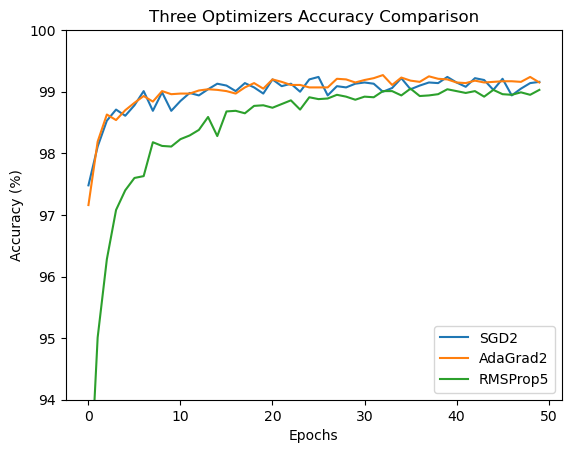

In [165]:
fig, ax = plt.subplots()

ax.plot(SGD_params_Acc[2], label='SGD2')
ax.plot(AdaGrad_params_Acc[2], label='AdaGrad2')
ax.plot(RMSprop_params_Acc[5], label='RMSProp5')

ax.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.ylim(94, 100)
plt.title("Three Optimizers Accuracy Comparison")
plt.savefig("5.1.png")

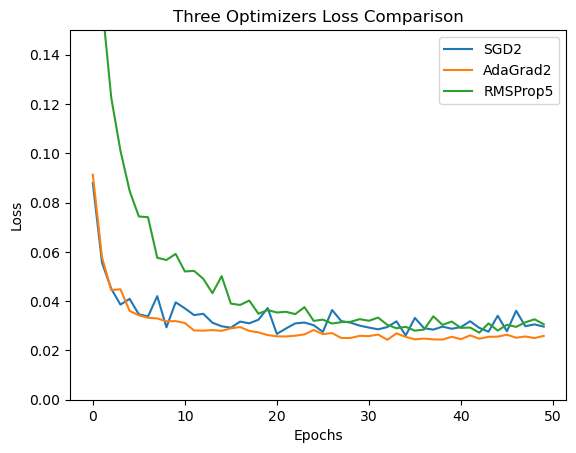

In [166]:
fig, ax = plt.subplots()

ax.plot(SGD_params_Loss[2], label='SGD2')
ax.plot(AdaGrad_params_Loss[2], label='AdaGrad2')
ax.plot(RMSprop_params_Loss[5], label='RMSProp5')

ax.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 0.15)
plt.title("Three Optimizers Loss Comparison")
plt.savefig("5.2.png")

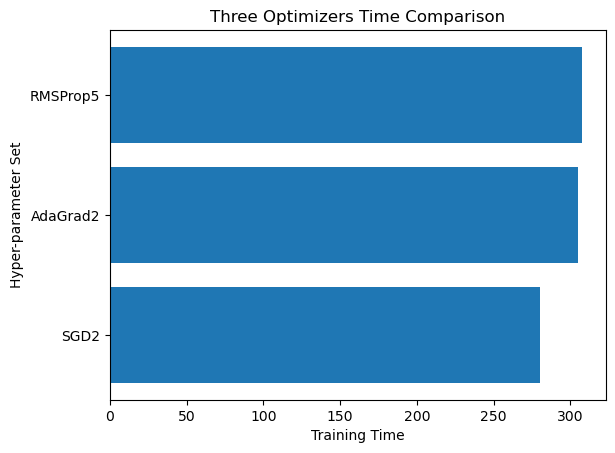

In [175]:
fig, ax = plt.subplots()

ax.barh(['SGD2', 'AdaGrad2', 'RMSProp5'], [SGD_params_Time[2], AdaGrad_params_Time[2], RMSprop_params_Time[5]])

plt.ylabel("Hyper-parameter Set")
plt.xlabel("Training Time")
plt.title("Three Optimizers Time Comparison")
plt.savefig("5.3.png")